## Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#unzip the dataset
#!unzip "/content/gdrive/MyDrive/SkinCancerDataset.zip" > /dev/null

#### Importing all the important libraries

In [3]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

#### Importing Skin Cancer Data

In [4]:
# Defining the path for train and test images

#data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
#data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

root_path = '/content/gdrive/MyDrive/app/skin_cancer'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [5]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

Total number of images mentioned on the upgrad 2357 matches with the above count 2239+118. So we are good

#### Use 80% of the images for training, and 20% for validation.

In [7]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [9]:
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.


# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


**Data Visualization**

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Found 2239 files belonging to 9 classes.


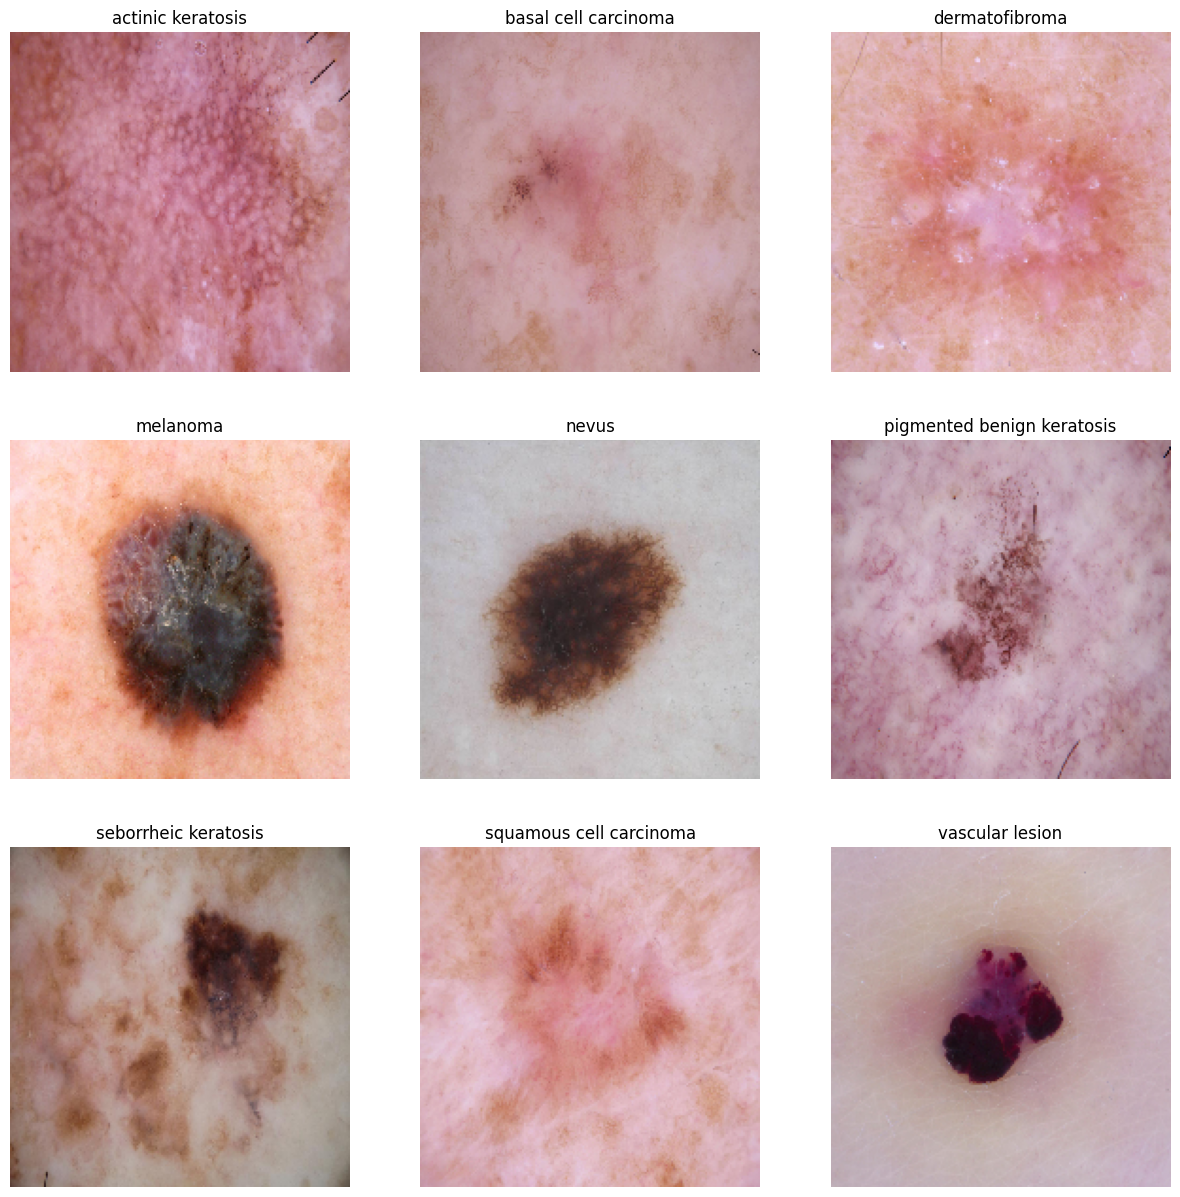

In [6]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [10]:


#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



#### Model 1 Create the model
Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [11]:


#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

# Images rescaled/ Rescaling layer
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

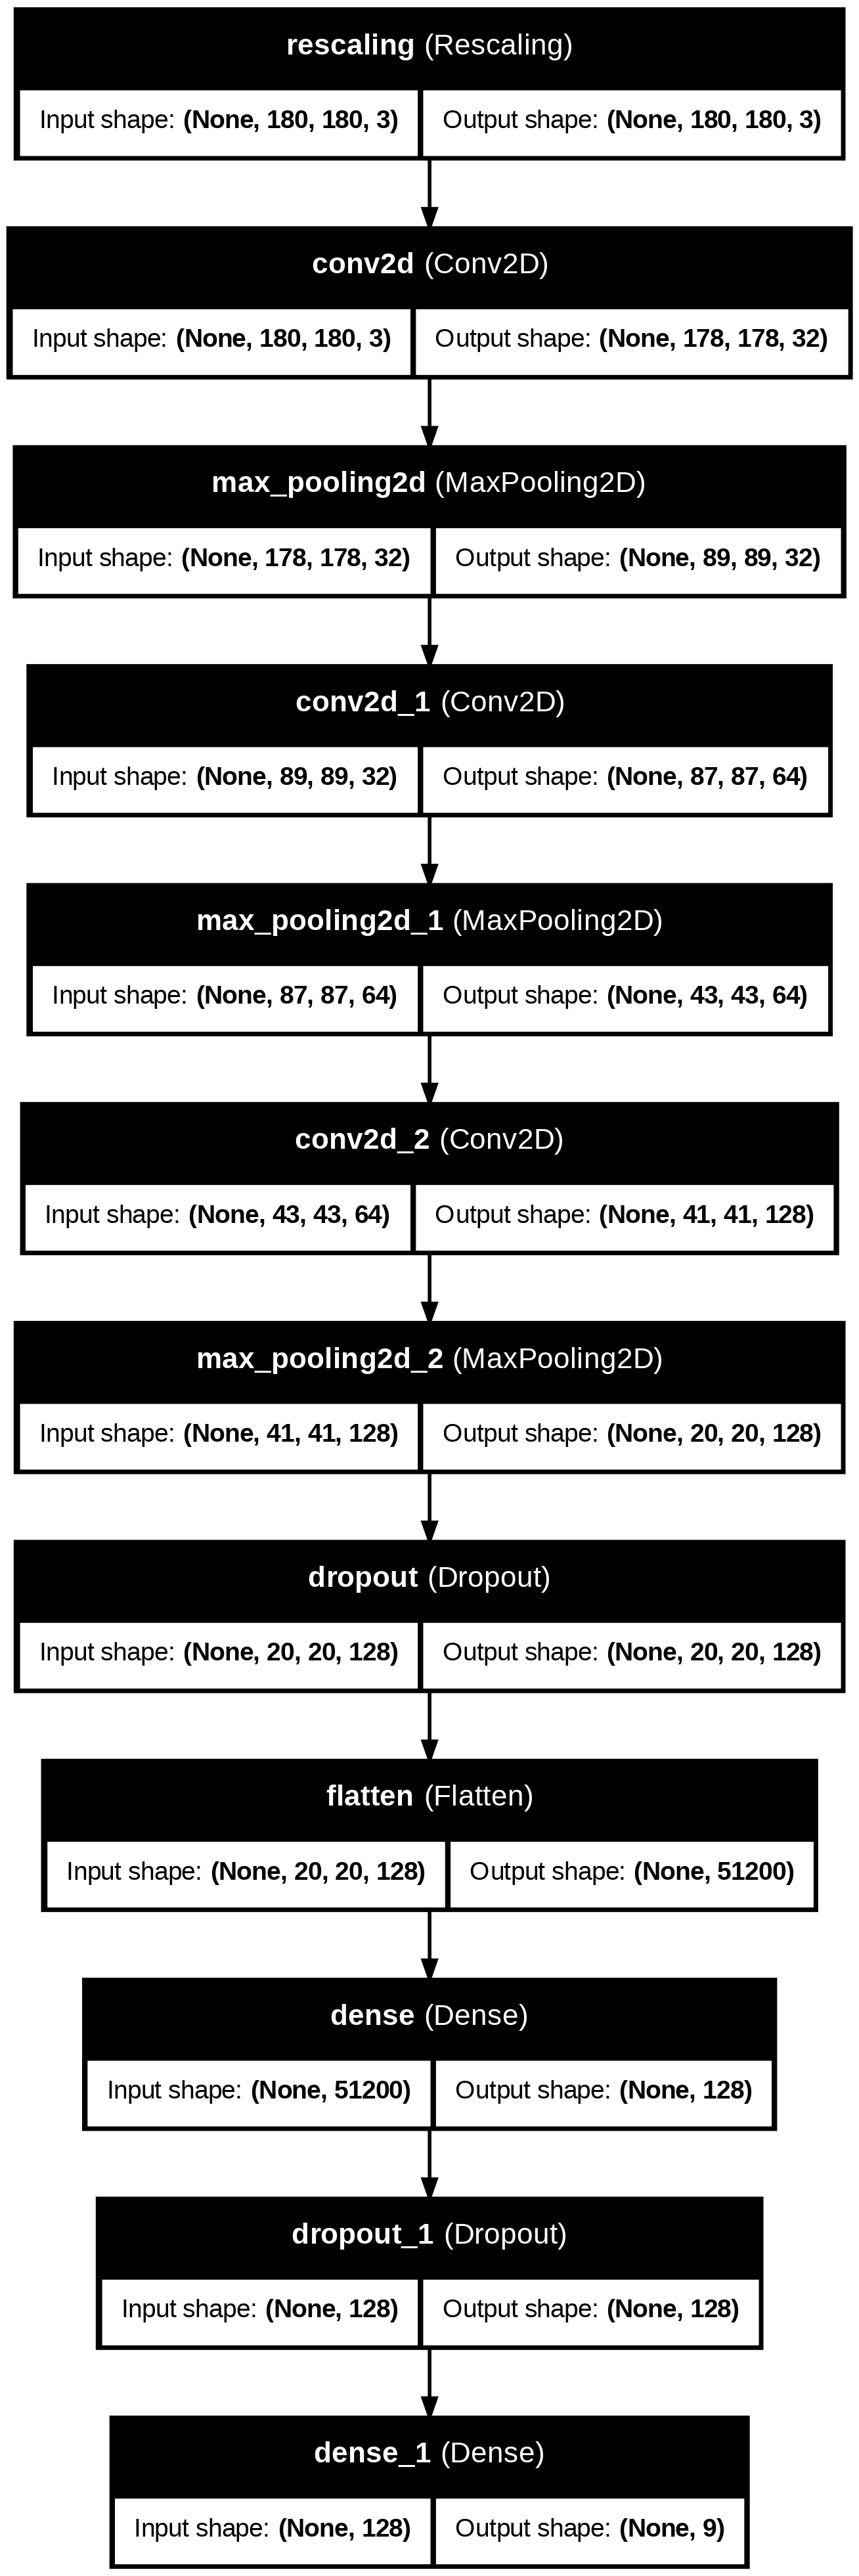

In [12]:

# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



#### Compile the model + Train the model

Choose an appropirate optimiser and loss function for model training

In [13]:

#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
try:
  checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
except ValueError as e:
  print(f"Error creating checkpoint: {e}")
#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)




# Train the model
epochs = 20
#epochs=1
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])






Epoch 1/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1886 - loss: 2.0988
Epoch 1: val_accuracy improved from -inf to 0.34452, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 183s 782ms/step - accuracy: 0.1909 - loss: 2.0949 - val_accuracy: 0.3445 - val_loss: 1.8306
Epoch 2/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3550 - loss: 1.7609
Epoch 2: val_accuracy improved from 0.34452 to 0.46980, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.3561 - loss: 1.7593 - val_accuracy: 0.4698 - val_loss: 1.5594
Epoch 3/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4457 - loss: 1.5622
Epoch 3: val_accuracy improved from 0.46980 to 0.48993, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4458 - loss: 1.5622 - val_accuracy: 0.4899 - val_loss: 1.4529
Epoch 4/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4864 - loss: 1.4774
Epoch 4: val_accuracy improved from 0.48993 to 0.51230, sav

#### first model train accuracy, val accuracy

#### Visualizing training results

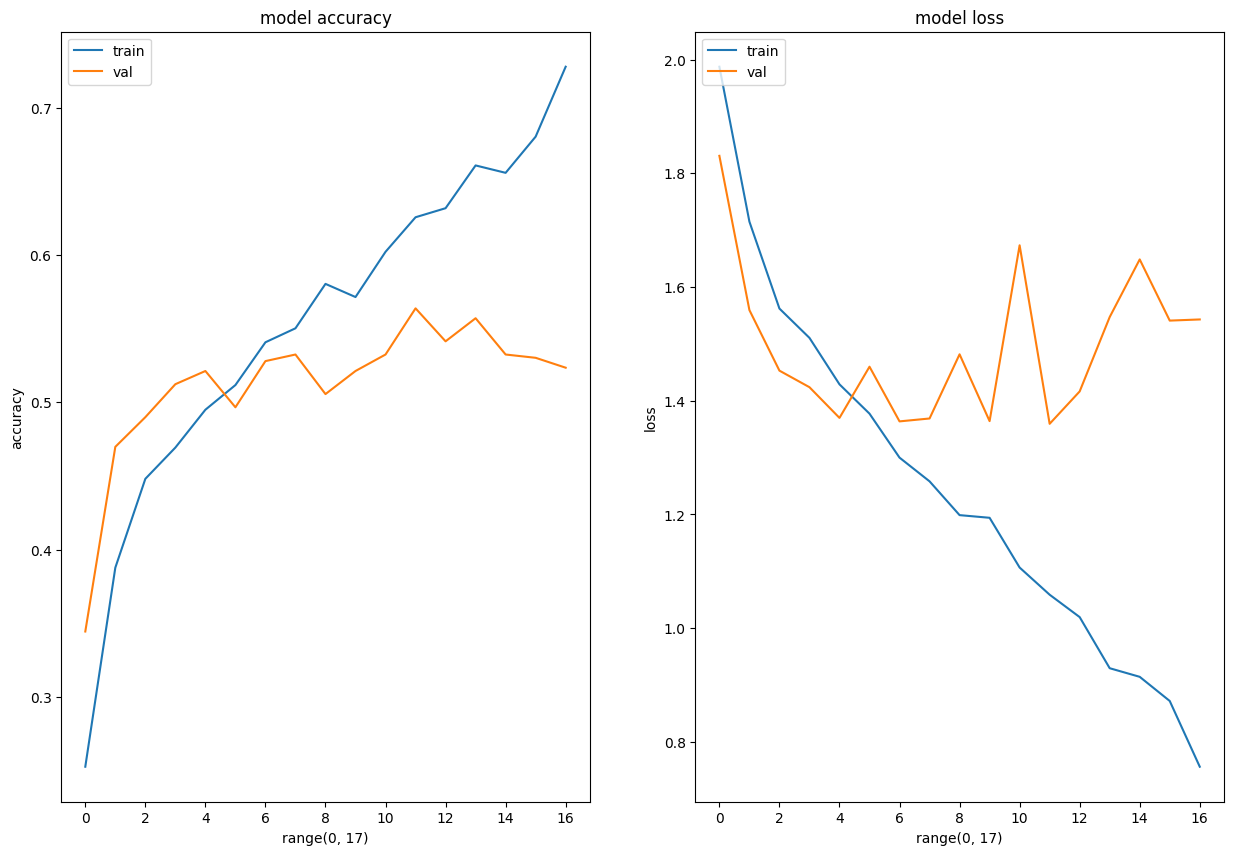

In [14]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()






In [15]:
# test dataset
test_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123
                                                             )

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the accuracy and loss on the test dataset
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.3525 - loss: 2.9027
Test Loss: 2.9187371730804443
Test Accuracy: 0.3813559412956238


#### Write your findings here

Model 1: Train accuracy 0.73, Val accuracy 0.52, and test accuracy of 0.38. This model shows overfitting

#### Model 2: Implement augmentation strategy to avoid overfitting

Create the model, compile and train the model

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

# Load the dataset
data_dir_train = '/content/gdrive/MyDrive/app/skin_cancer/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(180, 180),
    label_mode='categorical',
    seed=123,
    subset="training",
    validation_split=0.2
)

# Define the augmentation layer
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

# Apply augmentations on the images during training
def augment_images(image, label):
    image = data_augmentation(image)  # Apply augmentation
    return image, label

# Apply augmentation to the dataset
augmented_train_ds = train_ds.map(augment_images)

# Now, you can use `augmented_val_ds` for training or evaluation


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [17]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_batches = augmented_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_batches = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



Create the model, compile and train the model

In [18]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)))

#model.add(layers.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

In [19]:


#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
try:
  checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
except ValueError as e:
  print(f"Error creating checkpoint: {e}")
#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)


### Train the model

In [20]:

epochs = 20
#epochs=1
history = model.fit(train_batches, validation_data=valid_batches, epochs=epochs,callbacks=[checkpoint,earlystop])


Epoch 1/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1904 - loss: 2.2297
Epoch 1: val_accuracy improved from -inf to 0.27964, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.1917 - loss: 2.2242 - val_accuracy: 0.2796 - val_loss: 1.9267
Epoch 2/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2969 - loss: 1.8980
Epoch 2: val_accuracy improved from 0.27964 to 0.42729, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.2974 - loss: 1.8966 - val_accuracy: 0.4273 - val_loss: 1.6559
Epoch 3/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3838 - loss: 1.7194
Epoch 3: val_accuracy improved from 0.42729 to 0.44966, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.3843 - loss: 1.7177 - val_accuracy: 0.4497 - val_loss: 1.5768
Epoch 4/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4520 - loss: 1.5708
Epoch 4: val_accuracy improved from 0.44966 to 0.47875, savin

In [21]:
# test dataset
test_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123
                                                             )

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the accuracy and loss on the test dataset
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 995ms/step - accuracy: 0.3533 - loss: 3.3027
Test Loss: 2.963848829269409
Test Accuracy: 0.37288135290145874


#### Visualizing the results

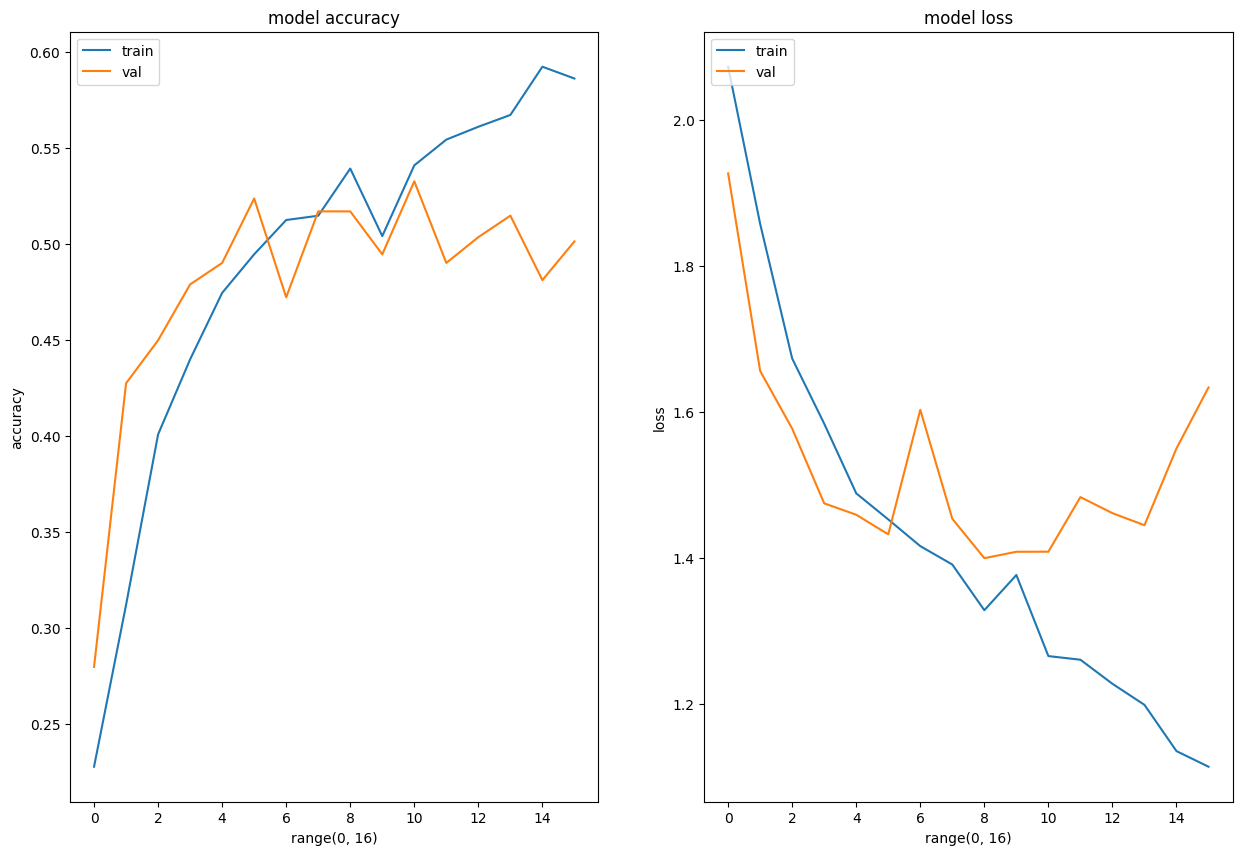

In [23]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()




#### Findings after model fit  
Model 2: Augmentation strategy

Train accuracy 0.58, validation accuracy 0.50, test accuracy 0.37

Post augmentation strategy, overfitting has reduced. Improvement observed.

#### Find the distribution of classes in the training dataset.

**Visualize distribution of classes in the training dataset.**

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,melanoma,438
2,squamous cell carcinoma,181
3,dermatofibroma,95
4,basal cell carcinoma,376
5,nevus,357
6,pigmented benign keratosis,462
7,seborrheic keratosis,77
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

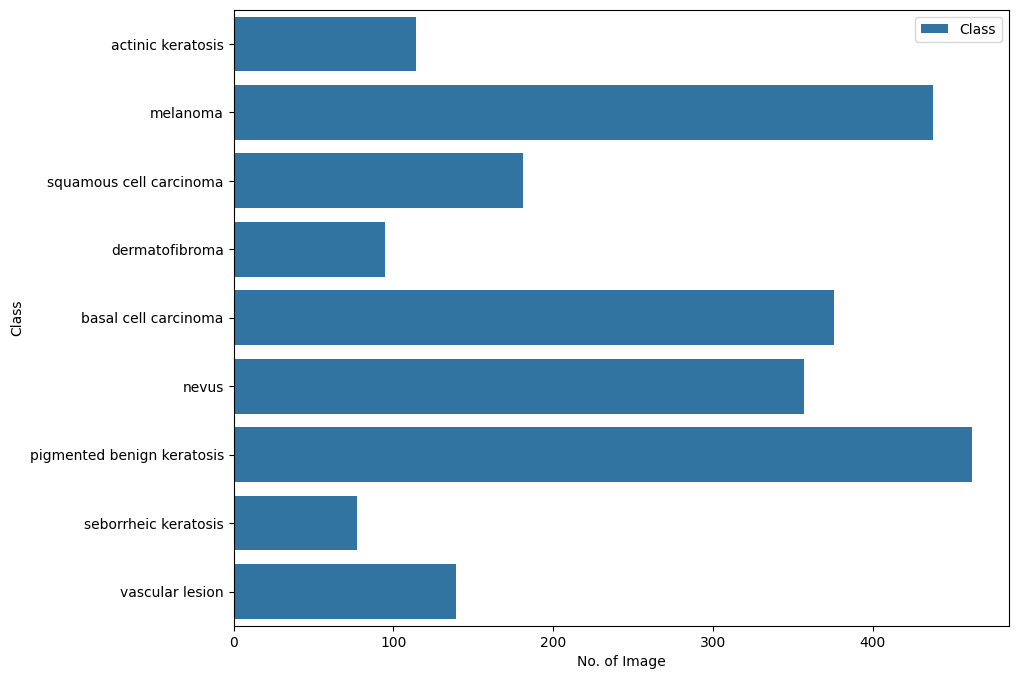

In [25]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

Write your findings here:
- Which class has the least number of samples? **seborrheic keratosis**

- Which classes dominate the data in terms proportionate number of samples? **pigmented benign keratosis**

# Rectify the class imbalance

You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
#install Augmentor
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.

2. Define a number of operations to perform on this data set using your Pipeline object.

3. Execute these operations by calling the Pipeline’s sample() method.

In [27]:
#path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
path_to_training_dataset="/content/gdrive/MyDrive/app/skin_cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x784B4249C9D0>: 100%|██████████| 500/500 [00:25<00:00, 19.78 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x784B4249CB80>: 100%|██████████| 500/500 [00:19<00:00, 25.54 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x784B345BB2B0>: 100%|██████████| 500/500 [00:19<00:00, 25.18 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x784B4249CB80>: 100%|██████████| 500/500 [01:21<00:00,  6.14 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x784B440DA440>: 100%|██████████| 500/500 [01:13<00:00,  6.85 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x784BB35EA0E0>: 100%|██████████| 500/500 [00:19<00:00, 25.95 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x784BC8446BF0>: 100%|██████████| 500/500 [00:41<00:00, 12.08 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x784B440DB6D0>: 100%|██████████| 500/500 [00:19<00:00, 25.64 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x784C53F46CE0>: 100%|██████████| 500/500 [00:19<00:00, 25.48 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.


Lets see the total of augmented data after adding new images to the original training data.


In [28]:
#Count total number of image generated by Augmentor.
from pathlib import Path

# Convert data_dir_train to a Path object
data_dir_train = Path('/content/gdrive/MyDrive/app/skin_cancer/Train')

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


So, now we have added 500*9 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# Model 3 with class imbalance
**Create a training dataset**

In [29]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [30]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Create a validation dataset

In [31]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create your model (without normalization)

In [32]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
try:
  checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
except ValueError as e:
  print(f"Error creating checkpoint: {e}")
#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [35]:
# Train the model
epochs = 30
#epochs=1
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2131 - loss: 2.0536
Epoch 1: val_accuracy improved from -inf to 0.40015, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 112ms/step - accuracy: 0.2135 - loss: 2.0527 - val_accuracy: 0.4001 - val_loss: 1.6104
Epoch 2/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3901 - loss: 1.5982
Epoch 2: val_accuracy improved from 0.40015 to 0.42019, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.3903 - loss: 1.5975 - val_accuracy: 0.4202 - val_loss: 1.4843
Epoch 3/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4661 - loss: 1.4133
Epoch 3: val_accuracy improved from 0.42019 to 0.48701, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4661 - loss: 1.4133 - val_accuracy: 0.4870 - val_loss: 1.3177
Epoch 4/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5110 - loss: 1.2812
Epoch 4: val_accuracy improved from 0.48701 to 

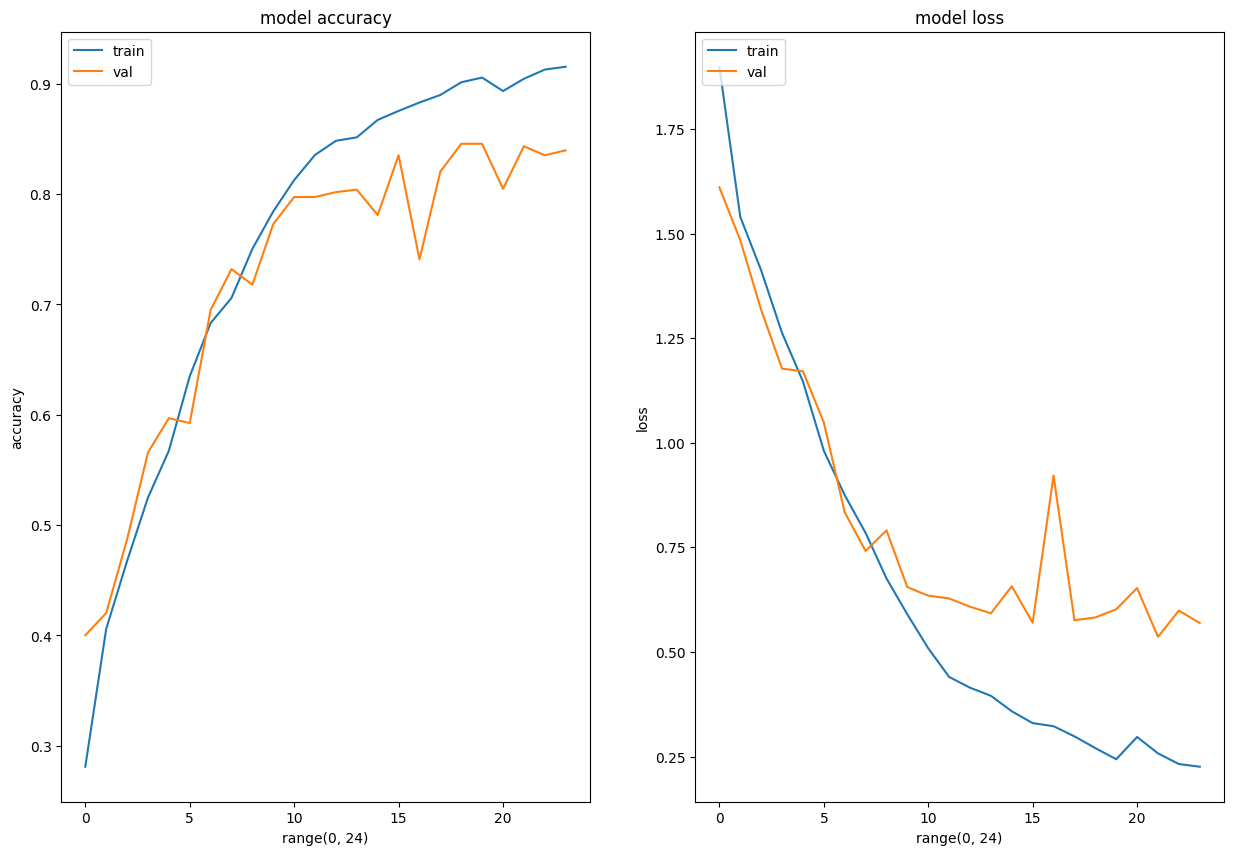

In [36]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Model Prediction

In [37]:

# test dataset
test_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123
                                                             )

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the accuracy and loss on the test dataset
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3491 - loss: 4.9810
Test Loss: 5.380537033081055
Test Accuracy: 0.33898305892944336


#### Train accuracy of 0.92, validation accuracy of 0.84 and test accuracy of 0.34.


#### Model 4: Create another model Class imbalance + (make sure to include normalization)

In [38]:
#from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization

In [39]:

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(180, 180, 3)))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Normalization added
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       7,225,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,367,465 (28.10 MB)

 Trainable params: 7,366,761 (28.10 MB)

 Non-trainable params: 704 (2.75 KB)

#### Compile your model (Choose optimizer and loss function appropriately)

In [40]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
try:
  checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
except ValueError as e:
  print(f"Error creating checkpoint: {e}")
#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)




**Train your model**

In [41]:
# Train the model
epochs = 30
#epochs=1
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3082 - loss: 2.2037
Epoch 1: val_accuracy improved from -inf to 0.20341, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 164ms/step - accuracy: 0.3085 - loss: 2.2022 - val_accuracy: 0.2034 - val_loss: 4.4017
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4551 - loss: 1.5349
Epoch 2: val_accuracy improved from 0.20341 to 0.28434, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.4552 - loss: 1.5346 - val_accuracy: 0.2843 - val_loss: 2.4493
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4973 - loss: 1.4011
Epoch 3: val_accuracy improved from 0.28434 to 0.56644, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.4972 - loss: 1.4011 - val_accuracy: 0.5664 - val_loss: 1.1942
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5505 - loss: 1.2328
Epoch 4: val_accuracy did not improve from 0

In [42]:

# test dataset
test_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123
                                                             )

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the accuracy and loss on the test dataset
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2317 - loss: 3.3021
Test Loss: 3.2755322456359863
Test Accuracy: 0.27966102957725525


Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings
Train accuracy: 0.78
val_accuracy: 0.53
Test accuracy 0.28

Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


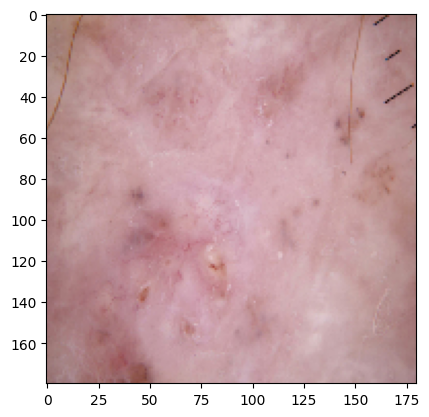

In [43]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

# Model 5: Class imbalance + batch normalization + augmenting strategy

#### Adding augmentation to avoid overfitting

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

# Load the dataset
data_dir_train = '/content/gdrive/MyDrive/app/skin_cancer/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(180, 180),
    label_mode='categorical',
    seed=123,
    subset="training",
    validation_split=0.2
)

# Define the augmentation layer
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

# Apply augmentations on the images during training
def augment_images(image, label):
    image = data_augmentation(image)  # Apply augmentation
    return image, label

# Apply augmentation to the dataset
augmented_train_ds = train_ds.map(augment_images)

# Now, you can use `augmented_val_ds` for training or evaluation

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [45]:


#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_batches = augmented_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_batches = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



Create your model

In [47]:

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(180, 180, 3)))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation='softmax'))

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       7,225,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,367,465 (28.10 MB)

 Trainable params: 7,366,761 (28.10 MB)

 Non-trainable params: 704 (2.75 KB)

Compile your model (Choose optimizer and loss function appropriately)

In [48]:


#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
try:
  checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
except ValueError as e:
  print(f"Error creating checkpoint: {e}")
#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)


Train your model

In [49]:
# Train the model
epochs = 30
#epochs=1
history = model.fit(augmented_train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.3085 - loss: 2.1723
Epoch 1: val_accuracy improved from -inf to 0.15071, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 431ms/step - accuracy: 0.3088 - loss: 2.1710 - val_accuracy: 0.1507 - val_loss: 12.2981
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.4264 - loss: 1.5970
Epoch 2: val_accuracy improved from 0.15071 to 0.38159, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 383ms/step - accuracy: 0.4263 - loss: 1.5971 - val_accuracy: 0.3816 - val_loss: 2.8226
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.4499 - loss: 1.5244
Epoch 3: val_accuracy did not improve from 0.38159
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 395ms/step - accuracy: 0.4499 - loss: 1.5245 - val_accuracy: 0.2442 - val_loss: 4.9862
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.4656 - loss: 1.4349
Epoch 4: val_accuracy did not improve from 0.38159
169/169 ━━━━━━━━━━━━

In [50]:

# test dataset
test_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123
                                                             )

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the accuracy and loss on the test dataset
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2712 - loss: 2.8071
Test Loss: 2.992279529571533
Test Accuracy: 0.27966102957725525


**Model 5 Findings**

Train acc: 0.48

Val acc: 0.32

Test acc: 0.28

Augmentation strategy doesnt work as expected with class imbalance



**Overall Findings**

**Analysis of Model Performance and Strategies**

Here's a breakdown of the different experiments and their potential implications:

**Experiment 1: No Data Augmentation, No Class Imbalance Handling, No Normalization**
* **Train Acc:** 0.73
* **Val Acc:** 0.52
* **Test Acc:** 0.38

* **Analysis:** The model seems to be overfitting, as the validation and test accuracies are significantly lower than the training accuracy. This could be due to a lack of data diversity and the model's inability to generalize to unseen data.

**Experiment 2: Data Augmentation, No Class Imbalance Handling, No Normalization**
* **Train Acc:** 0.58
* **Val Acc:** 0.5
* **Test Acc:** 0.37

* **Analysis:** Data augmentation seems to have helped reduce overfitting, but the overall performance is still not satisfactory. Normalization and class imbalance handling might be necessary for further improvement.

**Experiment 3: No Data Augmentation, Class Imbalance Handling, No Normalization**
* **Train Acc:** 0.92
* **Val Acc:** 0.84
* **Test Acc:** 0.34

* **Analysis:** Class imbalance handling have significantly improved the model's performance on the training and validation sets. However, the test accuracy is still low, indicating a potential overfitting issue.

**Experiment 4: No Data Augmentation, Class Imbalance Handling, Normalization**
* **Train Acc:** 0.78
* **Val Acc:** 0.53
* **Test Acc:** 0.28

* **Analysis:** This experiment adds normalization strategies, but the results are not as good as Experiment 3. This could be due to the specific data normalization techniques used or the hyperparameter settings.

**Experiment 5: Data Augmentation, Class Imbalance Handling, Normalization**

* **Train Acc:** 0.48
* **Val Acc:** 0.32
* **Test Acc:** 0.28

**Analysis:** While all three strategies were employed in this experiment, the model's performance is significantly lower than previous experiments. This could be due to several factors:



**Recommendations:**

1. **Data Augmentation:** Continue to experiment with different data augmentation techniques to improve generalization.
2. **Class Imbalance Handling:** Use techniques like oversampling, undersampling, or class weighting to address class imbalance.
3. **Normalization:** Normalize the input data to improve the model's convergence and performance.
4. **Regularization:** Use techniques like L1/L2 regularization or dropout to prevent overfitting.
5. **Hyperparameter Tuning:** Experiment with different hyperparameters like learning rate, batch size, and optimizer.
6. **Model Architecture:** Consider using more complex architectures like ResNet or EfficientNet, or explore transfer learning.
7. **Data Quality and Quantity:** Ensure that the training data is of high quality and sufficient quantity.

By carefully considering these factors and iteratively refining the model, it is possible to achieve better performance on the test set.
